# Text Classification Task

## Data

Download the '20 Newsgroups' data set from http://qwone.com/~jason/20Newsgroups/.

## Tasks
1. Provide important summary information and visualization on the data.
2. Classify the documents using a traditional (not deep learning) machine learning approach.
3. Classify the documents using a neural network.

# Loading the Data

In the spirit of creativity (and laziness)

Scikit-learn provides a function that downloads the 20newsgroups data and handles
- Parsing
- Categorization
- De-duplication
- Normalization (of target_names)
- Splitting training & test sets

#### Important Notes about Data Processing:

I stripped the document headers because almost every group can be identified with high probability from idiosyncratic features of their category's headers.

Our goal is to create a meaningful text classifier. Leaving the headers in place effectively teaches the classifier to internalize document structure rather modeling the topic being discussed.

Training and test sets are divided by a point-in-time. This is particularly important to categories where topics change over time. 

For example, topics discussed in 'talk.politics.mideast' will be event driven. If we train a model on a random sample of these documents we will likely see all topics that are discussed. 

To clarify: In January 2012 a suicide bomber targed the Al-Midan district of Damascus, Syria. This type of event would generate posts in the 'talk.politics.mideast' newsgroup. If we have trained a model to predict newgroup category using data prior to Jan 2012 it may never have seen a reference to Al-Midan. This makes the classification problem more difficult, and more realistic. Alternatively, if we train the model on a random sample of posts without considering time, the model will probably have seen other posts relating to Al-Midan in the 'talk.politics.mideast' category during training. In that case 'Al-Midan' will be a strong predictor of category.

In [1]:
from sklearn.datasets import fetch_20newsgroups

# Import Train, Test, and All data structures
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'))

# It would execute faster to combine the train and test subsets but this is more concise and safer
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [2]:
# Display record counts in training abd test set
cnt_all, cnt_train, cnt_test = len(newsgroups_all.data), len(newsgroups_train.data), len(newsgroups_test.data)
pct_train, pct_test = cnt_train/cnt_all, cnt_test/cnt_all
txt = 'Training/Testing Split'
print(txt)
print('-'*len(txt))
print('All Records:\t\t%d' % cnt_all)
print('Training Records:\t%d,\t%.2f%%' % (cnt_train, pct_train*100))
print('Testing Records:\t%d,\t%.2f%%' % (cnt_test, pct_test*100))

Training/Testing Split
----------------------
All Records:		18846
Training Records:	11314,	60.03%
Testing Records:	7532,	39.97%


In [3]:
# Lets look at the target names / categories
txt = 'Document Categories'
print(txt)
print('-'*len(txt))
newsgroups_all.target_names

Document Categories
-------------------


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# Category Frequency
### Will we need to over or undersample when modeling?

In [4]:
# What does the distribution of the data wrt targets look like?

# The data structure has a 'target' numpy series that matches with indexes that match 
import numpy as np
from keras.models import Model

# Use an anonymous function to lookup 'target name' from 'target' because
# we want to see plain text lables on our histogram rather than integers that represent a name
# vectorize() takes an element-wise function and converts it to operate on arrays
# It is more efficent than using a list comprehension and converting back to an array
target_to_target_name = np.vectorize(lambda x: newsgroups_train.target_names[x])
array_of_target_names = target_to_target_name(newsgroups_train.target)

Using TensorFlow backend.


In [5]:
# Inspect our new array of target names
print(array_of_target_names)

['rec.autos' 'comp.sys.mac.hardware' 'comp.sys.mac.hardware' ...,
 'comp.sys.ibm.pc.hardware' 'comp.graphics' 'rec.motorcycles']


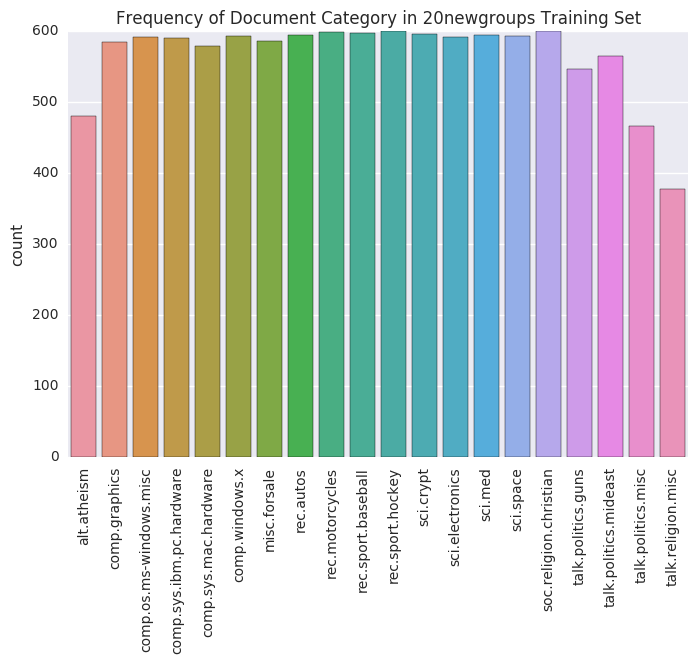

In [6]:
# Bar Plot of count/frequency by category

# Seaborn is a wrapper around Matplotlib that creates a high level abstraction for graphics with sane defaults
import seaborn as sns

# Create the plot
g = sns.countplot(sorted(array_of_target_names))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)
_ = g.set_title('Frequency of Document Category in 20newgroups Training Set')

# The distribution is fairly even

# In the real-world you'd want to experiment with 
#    oversampling talk.religion.misc, talk.politics.misc, and alt.atheism
#    or downsample the remaining categores

# For the purpose of not over-complicating this analysis, we'll assume that the
#    distribution is appropriately even 

# Vectorizing Text Data

In [7]:
# Inverse document frequency (TF-IDF) provides a simple way of extracting information content of terms
#     In practical terms it tells you how uniquely identifying a word is

# Other simple vectorizers include and CountVectorizer, HashingVectorizer.

# We also need to be careful about data snooping. We're making decisions about which words will be
#     valuable in the "predictive" model. We can't include test data when creating the
#     text vectorizing pre-processor because we would be allowing the pre-processor
#     to identify which words are "important" to the test set. Failing to make this separation before
#     vectorization will give the appearance of out-of-sample predictability during development in excess of
#     what will be found in real-world deployment.

In [8]:
# First we'll get the document vectors by performing a word count and a TF-IDF transform
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF Vectorizing object
source_vectorizer = TfidfVectorizer()

# Output data vectors representing documents

# Training Data (Fit data & transform)
X_train = source_vectorizer.fit_transform(newsgroups_train.data)
y_train = newsgroups_train.target

# Testing Data (Just transform)
X_test  = source_vectorizer.transform(newsgroups_test.data)
y_test  = newsgroups_test.target

# Training Models

In [9]:
# Now that our data is mapped into [vector -> class] format it is trivial to apply most classifiers
#     in the scikit-learn library.

# Interpreting accuracy
# ---------------------
# accuracy = correct_predictions / count_of_predictions


# How to interpret the classification report
# ------------------------------------------
# precision = tp / (tp + fp)    : 1.0 is perfect
# recall    = tp / (tp + fn)    : 1.0 is perfect
# f1-score  = weighted harmonic mean of precision and recall. Depends on parameter 'beta' which is 1 by default
#       More info at http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# support   = number of (true) occurances
# 
# where:
#       tp = true positives
#       fp = false positives
#       fn = false negatives

In [10]:
from sklearn import metrics
# Create a helper function to print common stats that can be computed from all classifier models
def shared_stats(model, title):
    global y_test
    
    print(title)
    print("-" * len(title))
    # Print the friendly representation of the model with default params
    print(model)

    # Deep Learning Models
    if isinstance(model,Model):
        # Parameterize model
        model.fit(X_train, y_train, validation_data=(X_test, y_test),
          nb_epoch=32, batch_size=256)
        
        # Predict dependent variable from test data
        y_pred = model.predict(X_test)
        
        # Revert from one-hot encoding of categories back to integers
        y_pred = [np.argmax(i) for i in y_pred]
        y_test = [np.argmax(i) for i in y_test]
    
    # Scikit Models
    else:
        # Train the model (fit() method is consistent across models)
        model.fit(X_train, y_train)
        # Predict dependent variable from test data
        y_pred = model.predict(X_test)

    # Compare predictions vs actual category
    score = metrics.accuracy_score(y_test, y_pred)
    print("\naccuracy:   %0.3f" % score)
    print(metrics.classification_report(y_test, y_pred, target_names=newsgroups_train.target_names))

## Naive Bayes

In [11]:
# Assumes features are conditionally independent of each other

# Multinominal corresponds to the distribution of input features
#     It is technically supposed used to represent integers like discrete counts but
#     in practice works well with fracitonal counts 
   
from sklearn.naive_bayes import MultinomialNB
shared_stats(MultinomialNB(alpha=0.009), 'Naive Bayes')

Naive Bayes
-----------
MultinomialNB(alpha=0.009, class_prior=None, fit_prior=True)

accuracy:   0.701
                          precision    recall  f1-score   support

             alt.atheism       0.57      0.45      0.50       319
           comp.graphics       0.65      0.71      0.68       389
 comp.os.ms-windows.misc       0.72      0.52      0.60       394
comp.sys.ibm.pc.hardware       0.60      0.71      0.65       392
   comp.sys.mac.hardware       0.73      0.70      0.71       385
          comp.windows.x       0.81      0.74      0.78       395
            misc.forsale       0.83      0.72      0.77       390
               rec.autos       0.74      0.73      0.74       396
         rec.motorcycles       0.76      0.73      0.75       398
      rec.sport.baseball       0.93      0.81      0.86       397
        rec.sport.hockey       0.60      0.93      0.73       399
               sci.crypt       0.72      0.75      0.74       396
         sci.electronics       0.72  

## Random Forest

In [12]:
# Ensemble learning method that uses sub-samples of data to train binary decision trees based on
#    maximum information gain at each 'node' or decision point. 
#
# They tend to be difficult to over-fit which makes them a good candidate when the number of features is large
#
# Training random forests can be cpu/time expensive but predictions are very fast

from sklearn.ensemble import RandomForestClassifier
shared_stats(RandomForestClassifier(n_estimators=200), 'Random Forest')

Random Forest
-------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

accuracy:   0.609
                          precision    recall  f1-score   support

             alt.atheism       0.40      0.31      0.35       319
           comp.graphics       0.56      0.61      0.58       389
 comp.os.ms-windows.misc       0.54      0.62      0.58       394
comp.sys.ibm.pc.hardware       0.62      0.59      0.60       392
   comp.sys.mac.hardware       0.66      0.64      0.65       385
          comp.windows.x       0.69      0.66      0.68       395
            misc.forsale       0.70      0.81      0.75       390
               rec.autos       0.42     

## Support Vector Machine

In [13]:
# Attempts to find the n-dimensional line/curve that maximally separates classes
#
# They have a tendency to over-fit if the number of features is high relative to the number of observation
#
# Multiple kernels are available. In practice you would try several. For the purpose of this comparison,
#    We'll use linear to avoid over-fitting.

from sklearn.svm import LinearSVC
shared_stats(LinearSVC(), 'Support Vector Machine (Linear Kernel)')

Support Vector Machine (Linear Kernel)
--------------------------------------
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

accuracy:   0.692
                          precision    recall  f1-score   support

             alt.atheism       0.54      0.49      0.51       319
           comp.graphics       0.67      0.71      0.69       389
 comp.os.ms-windows.misc       0.61      0.61      0.61       394
comp.sys.ibm.pc.hardware       0.62      0.65      0.63       392
   comp.sys.mac.hardware       0.75      0.69      0.72       385
          comp.windows.x       0.79      0.69      0.74       395
            misc.forsale       0.77      0.80      0.79       390
               rec.autos       0.74      0.71      0.73       396
         rec.motorcycles       0.78      0.76      0.77       398
      rec.sport.baseball   

### Traditional Machine Learning Discussion

If this were a real product we would pay much more attention to parameter choice within each model

sklearn.model_selection.GridSearchCV will perform an exhaustive search over multiple ranges of parameters
Parameter sweeps must occur on training data to avoid data snooping on out-of-sample performance

We would also inspect the words that each model found most useful to make sure we haven't accidentally trained on something inappropriate.

## Deep Learning

In [14]:
# We'll create a CNN using Keras and Tensorflow and pre-trained 100d GloVe word encodings

# GloVe word encodings (http://nlp.stanford.edu/projects/glove/) are vector representations for words. 
#     where the vectors are pre-trained on word co-occurrence statistics from a  multi-TB corpus.
#     The resulting representations showcase interesting linear substructures of the word vector space.

# Neural networks are notoriously bad with sparse data so we'll need a new, denser, document encoding.

In [15]:
embeddings_index = {}
EMBEDDING_DIM = 100 

with open('./glove.6B.100d.txt') as f:
    for row in f:
        fields = row.split()
        token = fields[0]
        vector = np.asarray(fields[1:], dtype='float32')
        embeddings_index[token] = vector
        
title = 'Loading GloVe %dd Word Encodings' % EMBEDDING_DIM
print(title)
print('-'*len(title))
print('Loaded Encodings: \t%d words/tokens' % len(embeddings_index))

Loading GloVe 100d Word Encodings
---------------------------------
Loaded Encodings: 	400000 words/tokens


In [16]:
# Our denser vector representation of documents will be sequences of word indexes where
# word indexes relate to their location in the GloVe encodings

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# Maximum Number of words allowed in analysis
MAX_NUM_WORDS = 15000

# Set Maximum length of input vector
MAX_SEQUENCE_LENGTH = 1000

# Limit Tokenizer's Word Count & Train
tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(newsgroups_train.data)

# Convert from training text to an array[int] where int represents a word index
X_train_seq = tokenizer.texts_to_sequences(newsgroups_train.data)
X_test_seq  = tokenizer.texts_to_sequences(newsgroups_test.data)

# 0 Pad Word Index Sequences with fewer then MAX_SEQUENCE_LENGTH features to ensure inputs are uniform
X_train = pad_sequences(X_train_seq, MAX_SEQUENCE_LENGTH)
X_test  = pad_sequences(X_test_seq, MAX_SEQUENCE_LENGTH)

# Convert newgroup category index to 1-hot encoding
y_train = to_categorical(np.asarray(newsgroups_train.target))
y_test  = to_categorical(np.asarray(newsgroups_test.target))

# Retrive the word index
word_index = tokenizer.word_index

In [17]:
# Review Training Data
title = 'Training Data'
print(title)
print('-'*len(title))
print('Observations by features:\t\t', X_train.shape)
print('Observations by one-hot category:\t', y_train.shape, '\n\n')

# Review Test Data
title = 'Testing Data'
print(title)
print('-'*len(title))
print('Observations by features:\t\t', X_test.shape)
print('Observations by one-hot category:\t', y_test.shape)

Training Data
-------------
Observations by features:		 (11314, 1000)
Observations by one-hot category:	 (11314, 20) 


Testing Data
------------
Observations by features:		 (7532, 1000)
Observations by one-hot category:	 (7532, 20)


In [18]:
# Note: Some of this cell was copied from documentation

# Now we prepare the the embedding matrix for the NN

# Pre-populate Embedding Matrix with 0s
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

# Iterate over words & add to embedding matrix
for word, i in word_index.items():
    
    # If word higher than max number
    if i >= MAX_NUM_WORDS:
        # Skip this iteration and continue looping
        continue
        
    # Retrive Word from Embeddings
    embedding_vector = embeddings_index.get(word, None)
    
    # If word was found in word embeddings
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense

# Create the Embedding Layer
embedding_layer = Embedding(MAX_NUM_WORDS, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,   
                            # Do not adjust word embeddings. We want to keep the GloVe encodings
                            trainable=False)

In [20]:
# Neural Network Layer Configuration sourced from Keras Documentation For Text Classification

# Parameters tuned for this data set may improve model performance but that is outside 
# the scope of this analysis.

# Stack the Model Layers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Embedding Layer
embedded_sequences = embedding_layer(sequence_input)

# Internals
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Predictions
preds = Dense(len(newsgroups_train.target_names), activation='softmax')(x)

# Model Object
model = Model(sequence_input, preds)

# Compile the model for Tensorflow
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [21]:
shared_stats(model, 'Deep Learning Model')

Deep Learning Model
-------------------
Train on 11314 samples, validate on 7532 samples
Epoch 1/32
11314/11314 [==============================] - 83s - loss: 2.8693 - acc: 0.0826 - val_loss: 2.6869 - val_acc: 0.1040

# Discussion

We created four models. Each model and its average precision score is shown below:
- Naive Bayes (71%)
- Random Forrest (61%)
- Support Vector Machine (70%)
- Deep Learning (58%)

These models and average precision scores are largely based on default parameters. Very little consideration was given to parameterization. Given that fact, it is not surprising that the simplest model performed best and the model that requires most parameterization performed worst (Naive Bays and Deep Learning respectively). These are cursory results and it is likely that the order would change with additional tuning.

The 20newgroups dataset fine for simple examples but it can understate the capability of algorithms known to perform best with lots of data (e.g. Random Forrest & Neural Nets). I would be interested to see the results of these tests with 1000x more data and better tuning.